# MALARIA DETECTION USING CLINICAL BLOOD PARAMETERS
### Bachelor of Science in Data Science - Year 2
### CSC2108 Artificial Intelligence - Advent 2025 Exam
### S24B38/026

In [44]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)

import joblib
import os

In [45]:
# Create folder for outputs
os.makedirs("outputs", exist_ok=True)

In [46]:

# LOAD DATA
df = pd.read_csv("/content/Malaria_Diseases_dataset.csv")

print(df.head())
print(df.shape)

      Sex  Age  Hemoglobin(Hb%)  Total WBC count(/cumm)  Neutrophils  \
0    Male   26             15.3                    5800           43   
1  Female   23             15.4                    5500           44   
2  Female   45             12.4                    4800           43   
3    Male   51             16.3                    7000           41   
4    Male   55             15.7                    5000           45   

   Lymphocytes  Total Cir.Eosinophils  HTC/PCV(%)  MCH(pg)  MCHC(g/dl)  \
0           41                    245        48.5    30.10       31.67   
1           42                    343        44.5    31.04       32.13   
2           42                    310        41.0    27.90       29.13   
3           43                    232        50.1    31.30       32.70   
4           42                    267        49.0    30.00       32.78   

   RDW-CV(%)  Platelet Count    Result  
0      15.22          195000  negative  
1      14.00          160000  negative  

In [47]:

# Check target column before cleaning
print("\nBefore cleaning - Result values:")
print(df['Result'].value_counts(dropna=False))

# CLEAN TARGET COLUMN
df['Result'] = df['Result'].str.strip().str.lower()

# There was one row with 'Positive' (capital P) in your dataset → fix it
df['Result'] = df['Result'].replace('Positive', 'positive')

print("\nAfter cleaning - Result values:")
print(df['Result'].value_counts())

# Final binary target
y = df['Result'].map({'positive': 1, 'negative': 0})
X = df.drop('Result', axis=1)

print("\nFinal class distribution:")
print(y.value_counts())
print(f"Positive (malaria): {y.sum()} ({y.mean()*100:.1f}%)")
print(f"Negative: {len(y)-y.sum()} ({(1-y.mean())*100:.1f}%)")


Before cleaning - Result values:
Result
negative    1122
positive    1067
Positive       1
Name: count, dtype: int64

After cleaning - Result values:
Result
negative    1122
positive    1068
Name: count, dtype: int64

Final class distribution:
Result
0    1122
1    1068
Name: count, dtype: int64
Positive (malaria): 1068 (48.8%)
Negative: 1122 (51.2%)


In [48]:
#BASIC EDA & PREPROCESSING

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sex                     2190 non-null   object 
 1   Age                     2190 non-null   int64  
 2   Hemoglobin(Hb%)         2190 non-null   float64
 3   Total WBC count(/cumm)  2190 non-null   int64  
 4   Neutrophils             2190 non-null   int64  
 5   Lymphocytes             2190 non-null   int64  
 6   Total Cir.Eosinophils   2190 non-null   int64  
 7   HTC/PCV(%)              2190 non-null   float64
 8   MCH(pg)                 2190 non-null   float64
 9   MCHC(g/dl)              2190 non-null   float64
 10  RDW-CV(%)               2190 non-null   float64
 11  Platelet Count          2190 non-null   int64  
 12  Result                  2190 non-null   object 
dtypes: float64(5), int64(6), object(2)
memory usage: 222.6+ KB
None
Sex                       0
A

In [49]:
# Encode Sex
X['Sex'] = X['Sex'].map({'Male': 0, 'Female': 1})

# Numerical columns
num_cols = ['Age', 'Hemoglobin(Hb%)', 'Total WBC count(/cumm)', 'Neutrophils',
            'Lymphocytes', 'Total Cir.Eosinophils', 'HTC/PCV(%)', 'MCH(pg)',
            'MCHC(g/dl)', 'RDW-CV(%)', 'Platelet Count']


In [50]:

# Handle outliers using IQR
for col in num_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    X[col] = X[col].clip(lower=lower, upper=upper)


In [51]:

# Standardize numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

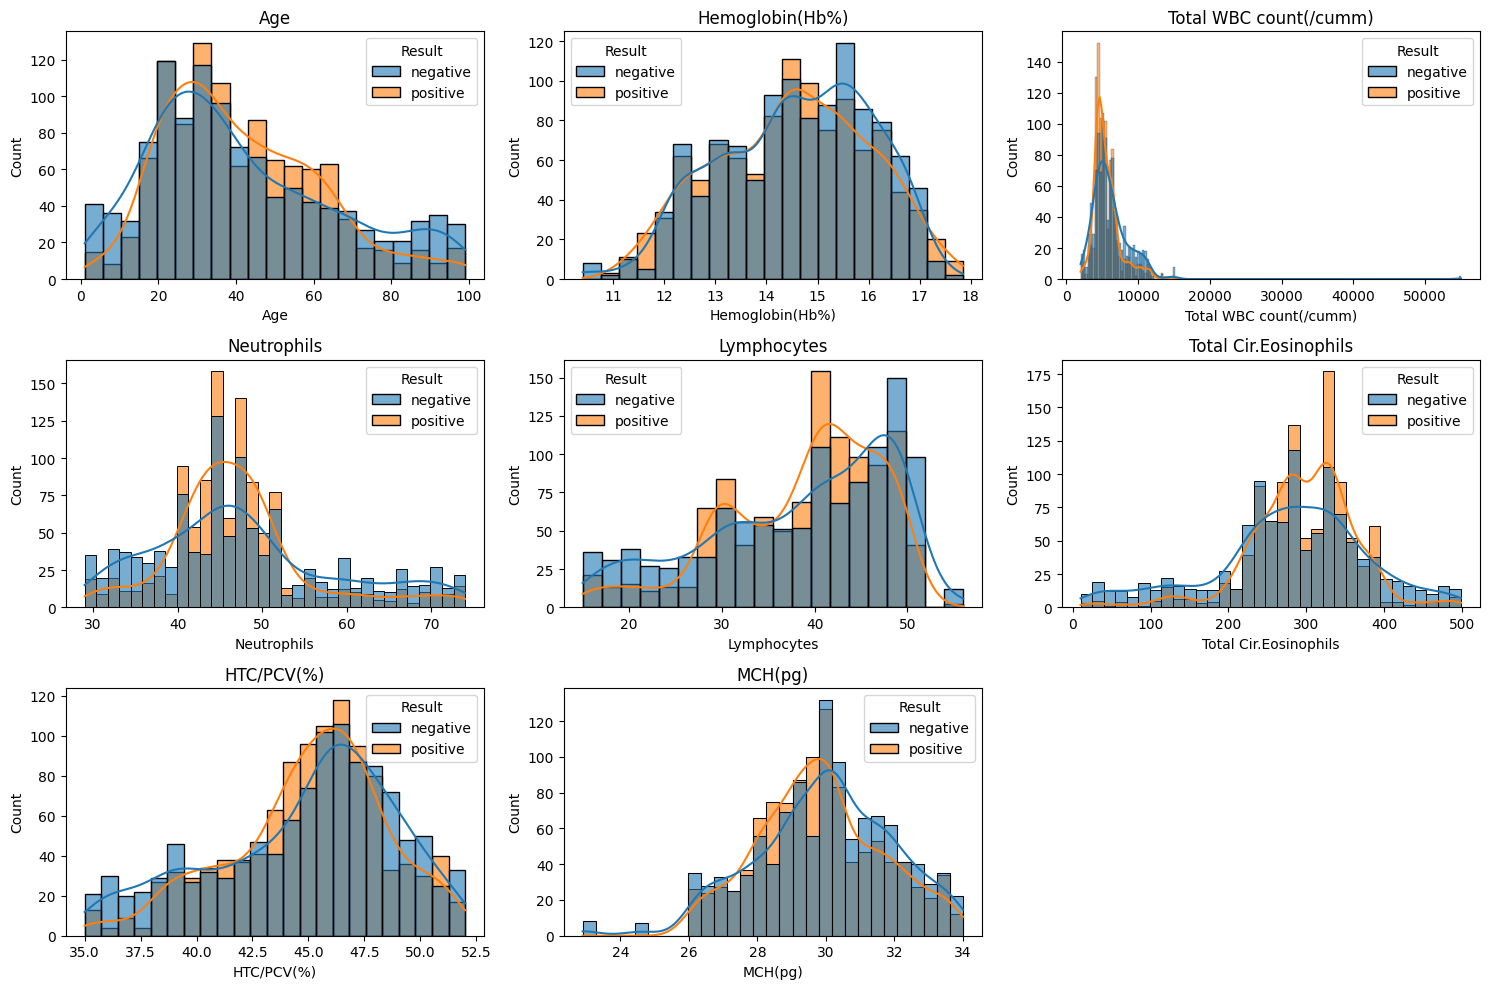

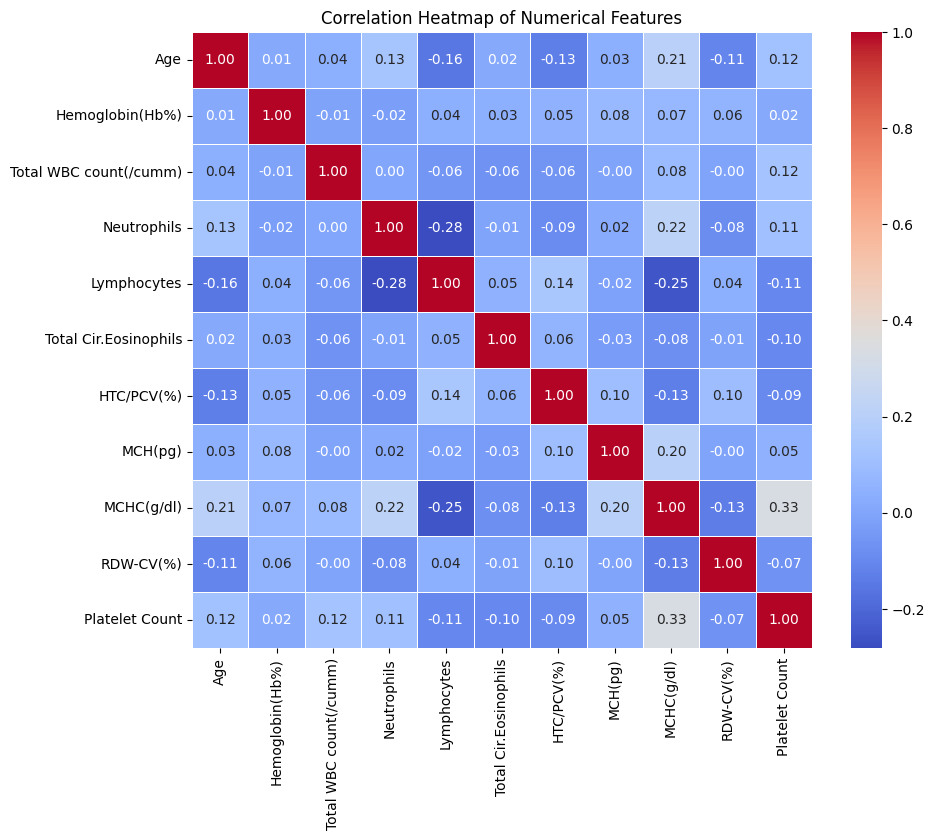

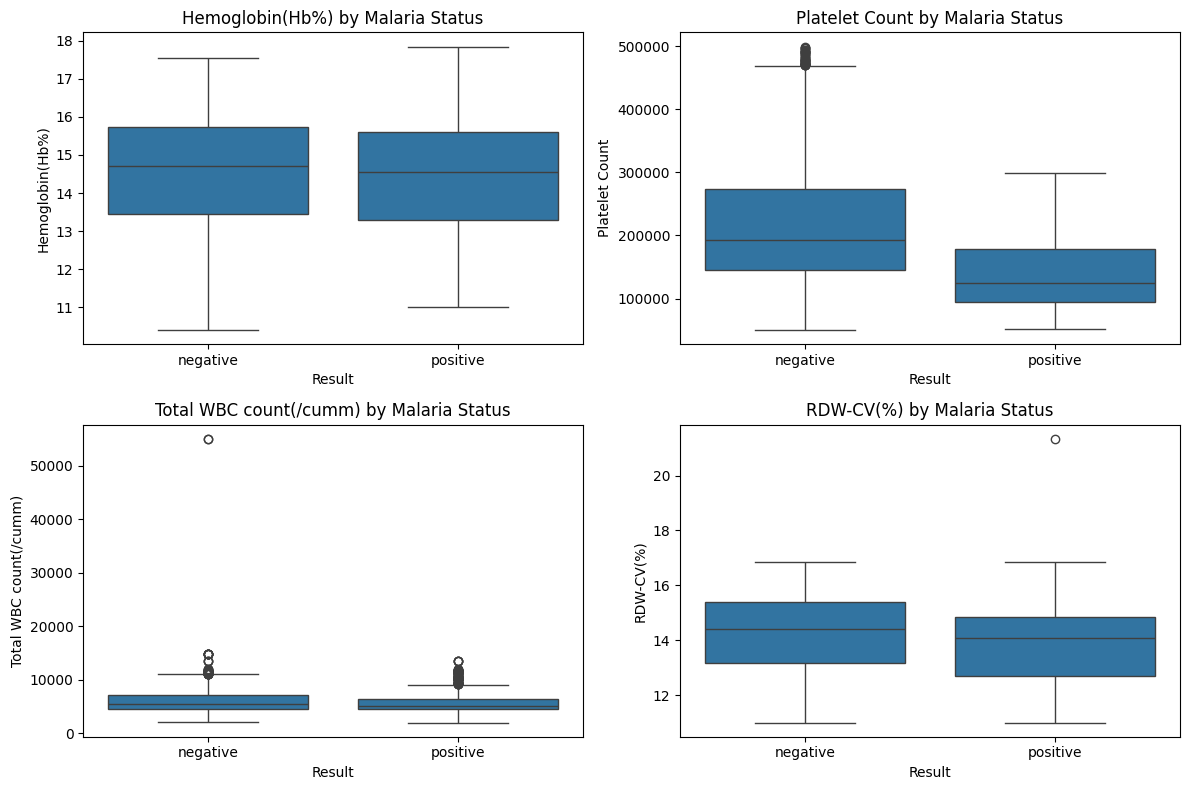

In [52]:
# EXPLORATORY DATA ANALYSIS and visualizations


# Distribution plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:8], 1):  # Show first 8
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, hue='Result', kde=True, alpha=0.6)
    plt.title(col)
plt.tight_layout()
plt.savefig("outputs/eda_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.savefig("outputs/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Boxplots by result
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Hemoglobin(Hb%)', 'Platelet Count', 'Total WBC count(/cumm)', 'RDW-CV(%)'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Result', y=col, data=df)
    plt.title(f"{col} by Malaria Status")
plt.tight_layout()
plt.savefig("outputs/boxplots_key_features.png", dpi=300, bbox_inches='tight')
plt.show()


In [53]:

# FEATURE SELECTION USING MUTUAL INFORMATION
print("\nPerforming Feature Selection using Mutual Information...")

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False).reset_index(drop=True)

print(mi_df)


Performing Feature Selection using Mutual Information...
                   Feature  MI_Score
0           Platelet Count  0.179731
1               HTC/PCV(%)  0.086093
2               MCHC(g/dl)  0.083751
3                  MCH(pg)  0.054244
4   Total WBC count(/cumm)  0.044880
5    Total Cir.Eosinophils  0.039061
6          Hemoglobin(Hb%)  0.035539
7              Neutrophils  0.033601
8                      Age  0.027765
9              Lymphocytes  0.025667
10               RDW-CV(%)  0.016243
11                     Sex  0.007372


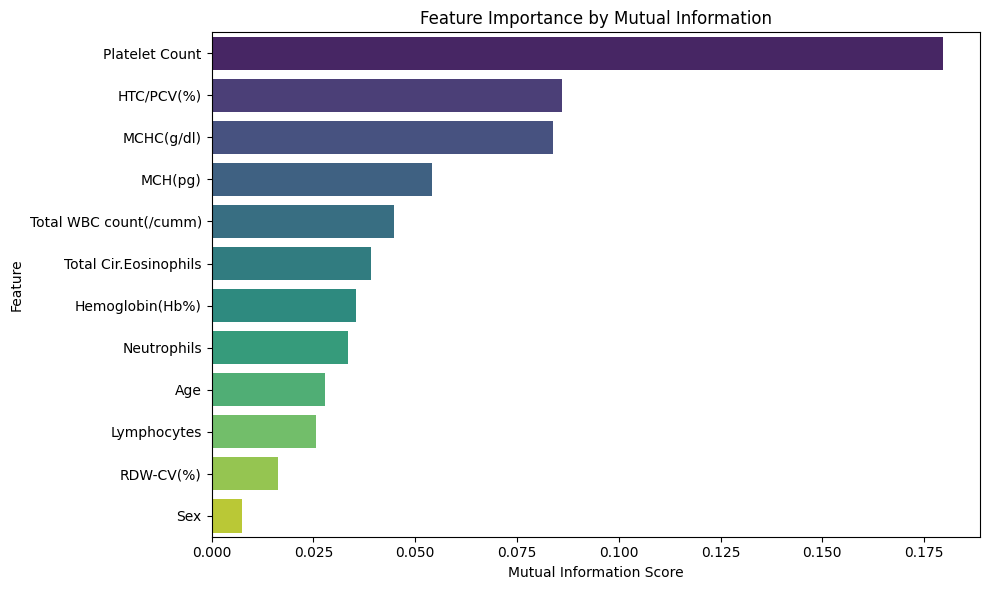

In [54]:

# Plot MI scores
plt.figure(figsize=(10, 6))
sns.barplot(x='MI_Score', y='Feature', data=mi_df, palette='viridis')
plt.title('Feature Importance by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.savefig("outputs/mutual_information_scores.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Select top 8 features
selector = SelectKBest(mutual_info_classif, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

print(f"\nSelected {len(selected_features)} features:")
print(selected_features)

# Save selected feature names
pd.DataFrame({'Selected_Features': selected_features}).to_csv("outputs/selected_features.csv", index=False)



Selected 8 features:
['Hemoglobin(Hb%)', 'Total WBC count(/cumm)', 'Neutrophils', 'Total Cir.Eosinophils', 'HTC/PCV(%)', 'MCH(pg)', 'MCHC(g/dl)', 'Platelet Count']


In [56]:
#TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 1752, Test size: 438


In [57]:
#  MODEL: RANDOM FOREST + HYPERPARAMETER TUNING
#Training Random Forest with Grid Search

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [58]:

#EVALUATION WITH 5-FOLD CV
print("\nPerforming 5-Fold Cross Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X_selected, y, cv=cv, scoring='recall')

print(f"5-Fold CV Recall scores: {cv_scores}")
print(f"Mean CV Recall: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Performing 5-Fold Cross Validation...
5-Fold CV Recall scores: [0.79812207 0.8028169  0.79906542 0.75700935 0.77102804]
Mean CV Recall: 0.7856 ± 0.0182


In [59]:
#FINAL MODEL PERFORMANCE ON TEST SET
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)


print("FINAL MODEL PERFORMANCE")

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall (Most Important) : {recall:.4f}  ← Critical for malaria detection!")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")


FINAL MODEL PERFORMANCE
Accuracy : 0.7534
Precision : 0.7246
Recall (Most Important) : 0.7991  ← Critical for malaria detection!
F1-Score : 0.7600
ROC-AUC  : 0.8121


In [60]:
# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.71      0.75       224
    Positive       0.72      0.80      0.76       214

    accuracy                           0.75       438
   macro avg       0.76      0.75      0.75       438
weighted avg       0.76      0.75      0.75       438



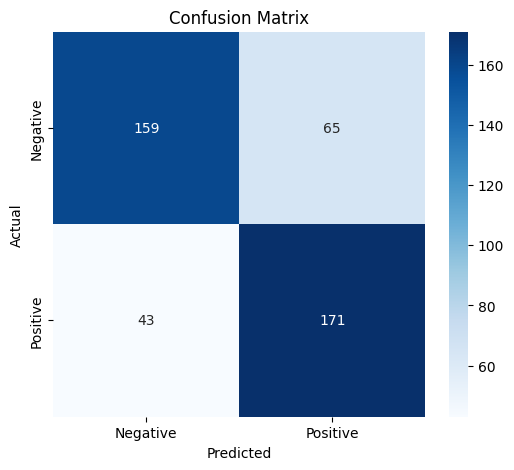

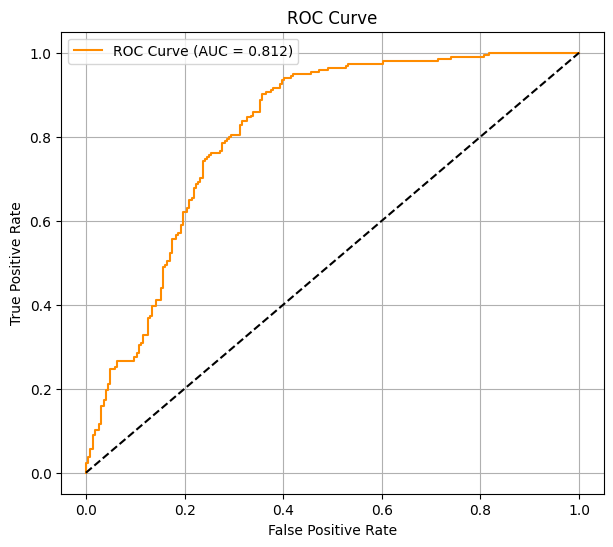

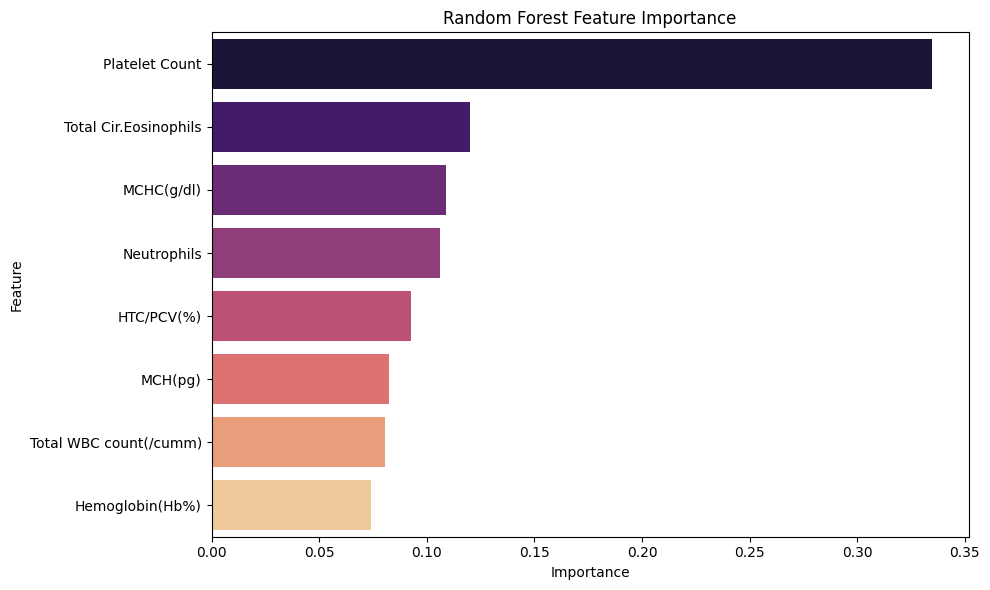

In [61]:



#  VISUALIZATIONS

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("outputs/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("outputs/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='magma')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig("outputs/feature_importance_rf.png", dpi=300, bbox_inches='tight')
plt.show()



In [62]:
# SAVE MODEL & SCALER
joblib.dump(best_rf, "outputs/malaria_detection_model.pkl")
joblib.dump(scaler, "outputs/scaler.pkl")
joblib.dump(selector, "outputs/feature_selector.pkl")
pd.DataFrame(selected_features, columns=['Selected Features']).to_csv("outputs/final_features.csv")

